In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch

if not torch.cuda.is_available():
    raise Exception('GPU not available.')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f'Device: {torch.cuda.get_device_name(0)} | Seed: {SEED}' )

Device: NVIDIA GeForce GTX 1060 6GB | Seed: 42


In [3]:
import os

DATA_FOLDER = 'data'
SCRIPT_FOLDER = 'scripts'

archive_path = os.path.join(DATA_FOLDER, 'archive.zip')
CLOUD_TEST_PATH = os.path.join(DATA_FOLDER, '38-Cloud_test')
CLOUD_TRAIN_PATH = os.path.join(DATA_FOLDER, '38-Cloud_training')

# flag to check if archive.zip has already been unzipped
is_archive_unzipped = os.path.exists(CLOUD_TEST_PATH) and os.path.exists(CLOUD_TRAIN_PATH)

# raise error if archive.zip has not been found and it has not been unzipped yet
if not os.path.exists(archive_path) and not is_archive_unzipped:
    raise Exception('Error: archive.zip is missing from data folder')

if is_archive_unzipped:
    print('Archive already unzipped.')

Archive already unzipped.


In [4]:
if (is_archive_unzipped == False):
    print('Unzipping archive...')
    !unzip data/archive.zip -d data
    print('Archive Unzipped!')
    

In [5]:
if os.path.exists(archive_path) and is_archive_unzipped:
    !rm data/archive.zip
    print('Archive Removed!')

In [6]:
if not os.path.exists('data/38-Cloud_test/test_gt'):
    print('Building test gt...')
    !python3 scripts/build_test_gt.py    

In [7]:
train_patches_name = 'training_patches_38-Cloud.csv'
test_patches_name = 'test_patches_38-Cloud.csv'

df_patches_train = pd.read_csv(os.path.join(CLOUD_TRAIN_PATH, train_patches_name))  # patches from 38-Cloud_training
df_patches_train['type'] = 'train'
df_patches_test = pd.read_csv(os.path.join(CLOUD_TEST_PATH, test_patches_name))     # patches from 38-Cloud_test
df_patches_test['type'] = 'test'

df_patches=pd.concat([df_patches_train,df_patches_test]).reset_index(drop=True)     # concatenate the two dataframes

print(f'Patches from train: {len(df_patches_train)} | Patches from test: {len(df_patches_test)}')
#df_patches.head()

tr_non_empty_patches_name = 'training_patches_38-cloud_nonempty.csv'
df_training_non_empty = pd.read_csv(os.path.join(DATA_FOLDER, tr_non_empty_patches_name))
df_training_non_empty['type'] = 'train'
print (f'Number of non-empty patches: {len(df_training_non_empty)}')


Patches from train: 8400 | Patches from test: 9201
Number of non-empty patches: 5155


In [12]:
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
from PIL import Image

class Cloud38Dataset(Dataset):
    def __init__(self, patches_df, pytorch=True, transform=None):
        super().__init__()
        
        self.transform = transform
        self.patches = [self.map_patches(f, t) for f, t in zip(patches_df['name'], patches_df['type'])]
        self.pytorch = pytorch        
        self.mean = None
        self.std = None

    def map_patches(self, file_name, type_p):

        folder_path = Path(CLOUD_TEST_PATH) if type_p == 'test' else Path(CLOUD_TRAIN_PATH)

        channels = ['red', 'green', 'blue', 'nir', 'gt']
        paths = {}

        for i in channels:
            path = folder_path / Path(f'{type_p}_{i}') / Path(f'{i}_' + file_name + '.TIF')
            if not os.path.exists(path):
                raise Exception(f'Error: {path} does not exist' )
            paths[i] = path   

        return paths
    
    def __len__(self):
        return len(self.patches)

    def to_array(self, i, invert=False, include_nir=False):
        rgb = np.stack([
            np.array(Image.open(self.patches[i]['red'])),
            np.array(Image.open(self.patches[i]['green'])),
            np.array(Image.open(self.patches[i]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.patches[i]['nir'])), axis=2)
            rgb = np.concatenate([rgb, nir], axis=2)

        if invert:
            rgb = rgb.transpose((2, 0, 1))
        
        return rgb / np.iinfo(rgb.dtype).max # images are uint16, so max is 65535
          
    
    def to_mask(self, i, add_dims=False):
        mask = np.array(Image.open(self.patches[i]['gt']))
        mask = np.where(mask == 255, 1, 0)

        if add_dims:
            return np.expand_dims(mask, 0)
        else:
            return mask
        
    def __getitem__(self, i):
        img = torch.tensor(self.to_array(i, invert=self.pytorch), dtype=torch.float32)
        mask = torch.tensor(self.to_mask(i, add_dims=False), dtype=torch.float32)

        # Apply transformations if defined
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']

        return img, mask
        

In [13]:
data_train = Cloud38Dataset(df_patches_train)
print(f'Data has been loaded | Length: {len(data_train)}')

Data has been loaded | Length: 8400


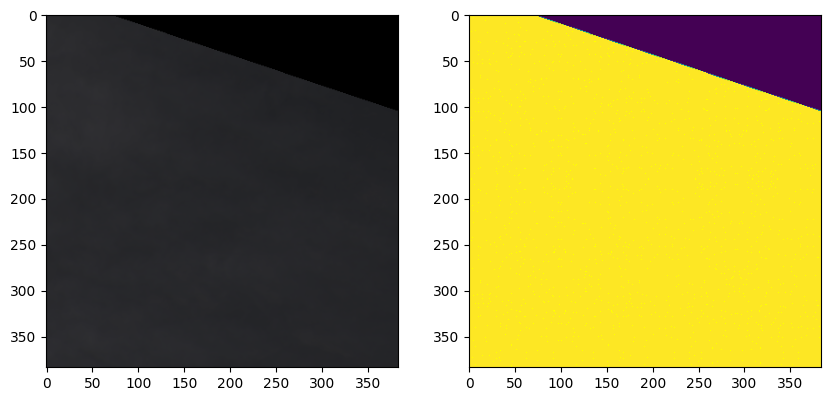

In [17]:
image_index = np.random.randint(0, len(data_train))

# we change the default colormap to make sure that 0 is purple and 1 is yellow
# even when the mask has only 0s or 1s
custom_cmap = plt.colormaps['viridis']
custom_cmap.set_under('purple')
custom_cmap.set_over('yellow')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(data_train.to_array(image_index, include_nir=False))
ax[1].imshow(data_train.to_mask(image_index) , cmap=custom_cmap, vmin=0, vmax=1)


In [41]:
data_test_val = Cloud38Dataset(df_patches_test, test=True)
print(f'Data has been loaded | Length: {len(data_test_val)}')

Data has been loaded | Length: 9201


In [ ]:

image_index = np.random.randint(0, len(data_test_val))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(data_test_val.to_array(image_index, include_nir=False))
ax[1].imshow(data_test_val.to_mask(image_index), cmap = custom_cmap, vmin=0, vmax=1)
#7892

In [ ]:
data_train = Subset(data_train, np.random.randint(0, len(data_train), 200))
data_test_val = Subset(data_test_val, np.random.randint(0, len(data_test_val), 200))

In [ ]:
########### BREAK ############

In [ ]:
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from model import UNET
from tqdm import tqdm
from utils import (
    load_checkpoint, 
    save_checkpoint,    
    check_accuracy,
    save_predictions_as_imgs,
)


# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = device
BATCH_SIZE = 16
NUM_EPOCHS = 100
IMAGE_SIZE = 256
PIN_MEMORY = True
LOAD_MODEL= True

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():
    train_transform = A.Compose([
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),       
    ])

    val_transforms = A.Compose([
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),       
    ])

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader = DataLoader(
        dataset=data_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=PIN_MEMORY,
    )

    val_loader = DataLoader(
        dataset=data_test_val,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=PIN_MEMORY,
    )

    if LOAD_MODEL:
            load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)           

    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)         

        # save model
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check acc
        check_accuracy(val_loader, model, device=DEVICE)
        
        #save
        save_predictions_as_imgs(
            val_loader, model, folder='imgs/', device=DEVICE
        )



if __name__ == "__main__":
    main()

In [ ]:
from torch.utils.data import DataLoader

IMAGE_SIZE = 384

loader_train = DataLoader(data_train, batch_size=32)

#print(loader_train)

pixel_sum = torch.tensor([0.0, 0.0, 0.0])
pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

for x, y in loader_train:
    pixel_sum += x.sum(axis=(0, 2, 3))
    pixel_sum_sq += (x ** 2).sum(axis=(0, 2, 3))

count = len(data_train) * IMAGE_SIZE * IMAGE_SIZE
mean = pixel_sum / count
var = (pixel_sum_sq / count) - (mean ** 2)
std = torch.sqrt(var)

print(f'Computed mean and std for the dataset:\n Mean: {mean} | Std: {std}')

In [ ]:
# normalize the dataset using the mean and std computed above
data_train.mean = mean
data_train.std = std

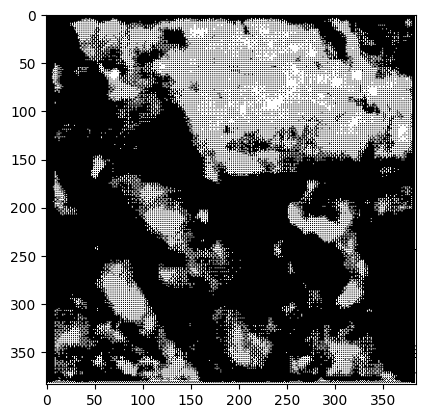

In [29]:
pred_img_p = 'imgs/pred_0.png'
pred_img = Image.open(pred_img_p)
pred_img = np.array(pred_img)
plt.imshow(pred_img)